## Pairwise comparison of clusters with ClusterDE

Maybe this works....

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd


import importlib

## Example data

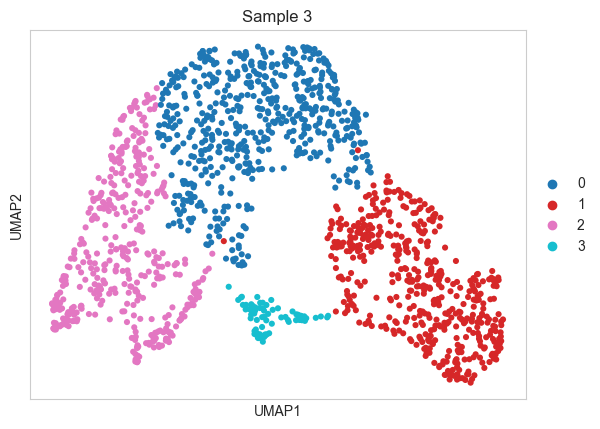

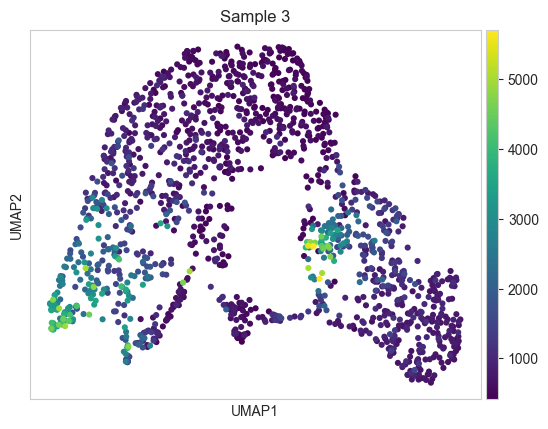

In [2]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

sc.pl.umap(data_gene, color="total_counts", palette="tab10", title="Sample 3", cmap="viridis")
plt.show()

AnnData object with n_obs × n_vars = 644 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std'
    uns: 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 644 × 5415
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_

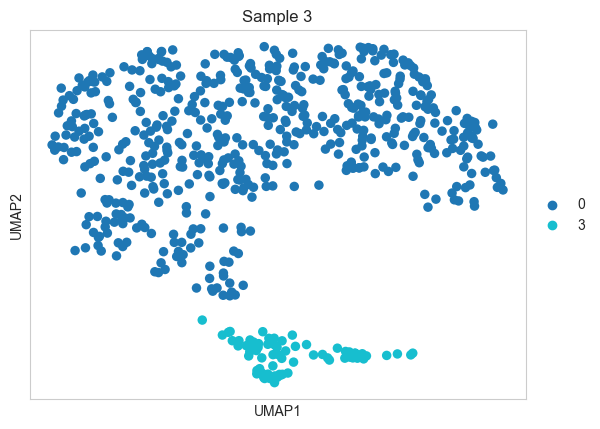

In [3]:
clusters_subset = ["0", "3"]
data_subset = data_gene[data_gene.obs["leiden_opt"].isin(clusters_subset)].copy()
print(data_subset)
sc.pp.filter_genes(data_subset, min_cells=2)
sc.pp.filter_cells(data_subset, min_genes=2)
print(data_subset)
sc.pl.umap(data_subset, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data of same size

In [4]:
# drop pre-fitted columns from var just to test if nb is fitted automatically
data_subset.var.drop(["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "nb_overdisp_cutoff_bfgs", "nb_overdisp_bfgs"], axis=1, inplace=True)
data_subset.var.columns

Index(['feature_types', 'genome', 'n_cells_by_counts', 'mean_counts',
       'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts',
       'log1p_total_counts', 'PAO1_ID', 'TU_ID',
       'Regulation - transcription units of gene', 'n_cells', 'var_counts',
       'is_scd_outlier', 'mean', 'std'],
      dtype='object')

In [5]:
tc = np.sum(data_subset.layers["counts"], axis=0)
print(tc.shape)
print(np.min(tc))

(1, 5415)
2.0


In [6]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_subset, layer="counts", flavor="mle")
data_subset.var["nb_mean_mle"] = data_subset.var["nb_mean"]
data_subset.var["nb_overdisp_mle"] = data_subset.var["nb_overdisp"]
nb.estimate_overdisp_nb(data_subset, layer="counts", flavor="BFGS")


Fitting feature 100/5415
Fitting feature 200/5415
Fitting feature 300/5415
Fitting feature 400/5415
Fitting feature 500/5415
Fitting feature 600/5415
Fitting feature 700/5415
Fitting feature 800/5415
Fitting feature 900/5415
Fitting feature 1000/5415
Fitting feature 1100/5415
Fitting feature 1200/5415
Fitting feature 1300/5415
Fitting feature 1400/5415
Fitting feature 1500/5415
Fitting feature 1600/5415
Fitting feature 1700/5415
Fitting feature 1800/5415
Fitting feature 1900/5415
Fitting feature 2000/5415
Fitting feature 2100/5415
Fitting feature 2200/5415
Fitting feature 2300/5415
Fitting feature 2400/5415
Fitting feature 2500/5415
Fitting feature 2600/5415
Fitting feature 2700/5415
Fitting feature 2800/5415
Fitting feature 2900/5415
Fitting feature 3000/5415
Fitting feature 3100/5415
Fitting feature 3200/5415
Fitting feature 3300/5415
Fitting feature 3400/5415
Fitting feature 3500/5415
Fitting feature 3600/5415
Fitting feature 3700/5415
Fitting feature 3800/5415
Fitting feature 3900/

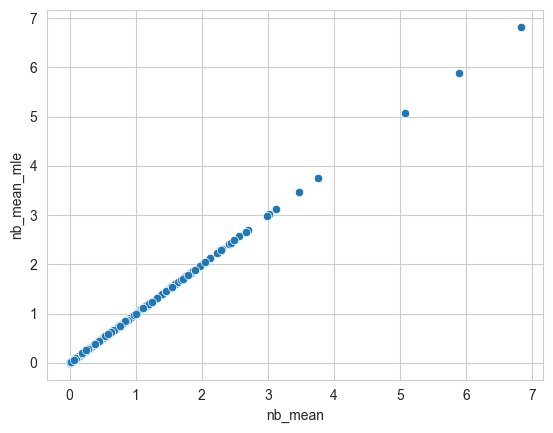

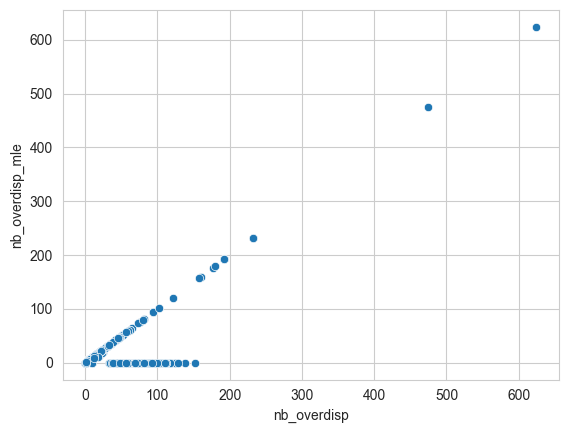

In [7]:
sns.scatterplot(data_subset.var, x="nb_mean", y="nb_mean_mle")
plt.show()

sns.scatterplot(data_subset.var, x="nb_overdisp", y="nb_overdisp_mle")
plt.show()


In [8]:
importlib.reload(cd)
data_null_gen = cd.generate_nb_data_copula(data_subset, rng_seed=1234, nb_flavor="BFGS")
data_null_gen

AnnData object with n_obs × n_vars = 644 × 5415

## Diagnostic plots

In [9]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

Mean comparison
--> Looks good

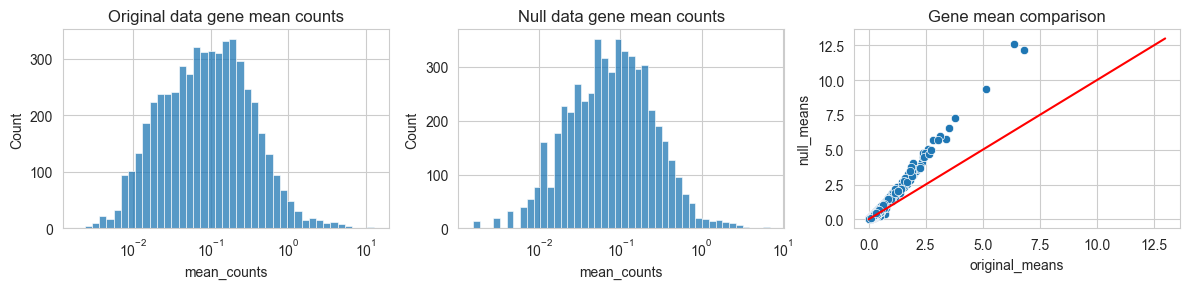

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_subset.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_null_gen.var["mean_counts"], "null_means": data_subset.var["mean_counts"]})
g = sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_subset.var["mean_counts"]))], [0, np.ceil(np.max(data_subset.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

Variance comparison
--> Variances are underestimated for large variances and 

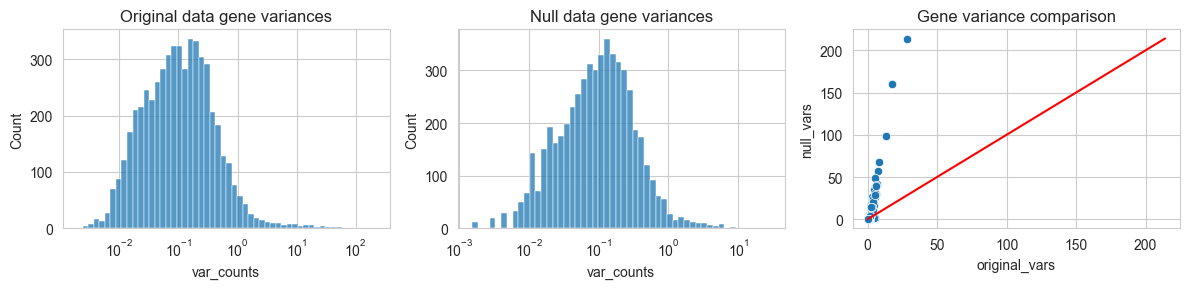

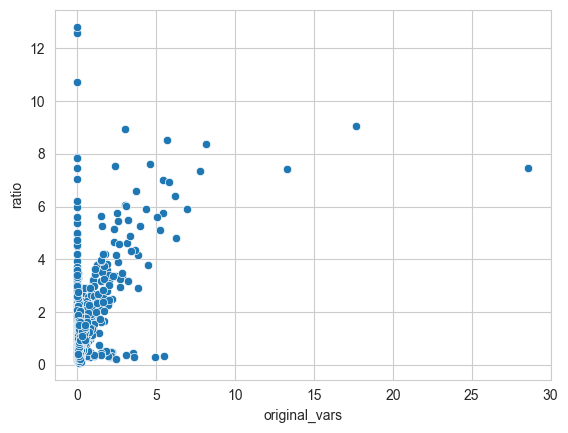

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_subset.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_null_gen.var["var_counts"], "null_vars": data_subset.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
g = sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_subset.var["var_counts"]))], [0, np.ceil(np.max(data_subset.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

sns.scatterplot(var_df, x="original_vars", y="ratio")
plt.show()

Comparison of gene-gene correlations
--> Correlations are generally underestimated

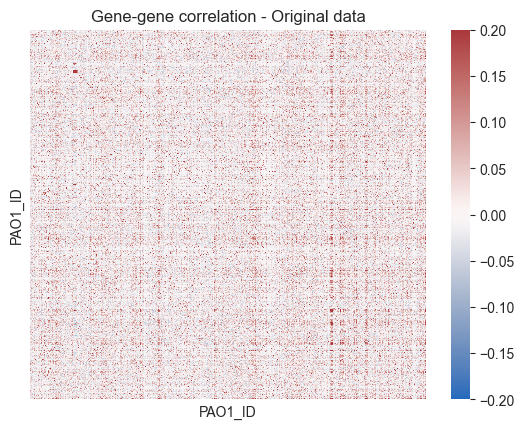

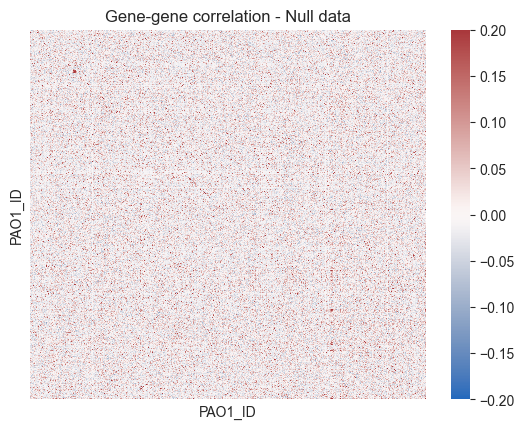

In [12]:
cor_orig = np.corrcoef(data_subset.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_subset.var_names, columns=data_subset.var_names)

cor_gen = np.corrcoef(data_null_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_subset.var_names, columns=data_subset.var_names)

sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

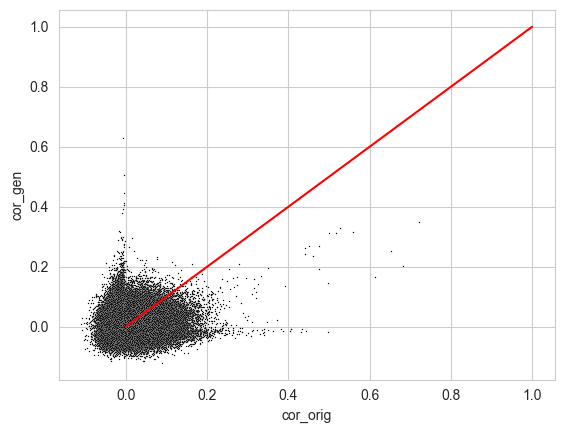

In [13]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### process newly generated data

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


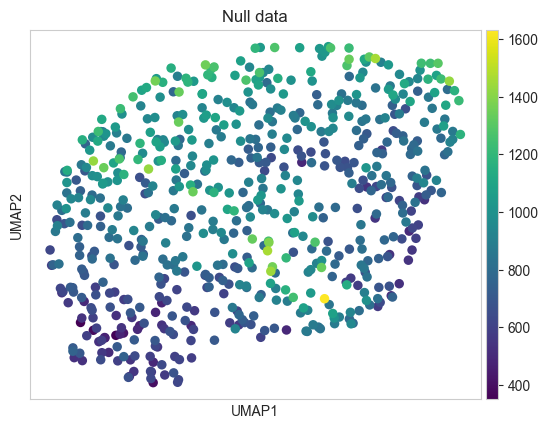

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen)

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp_cutoff"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()

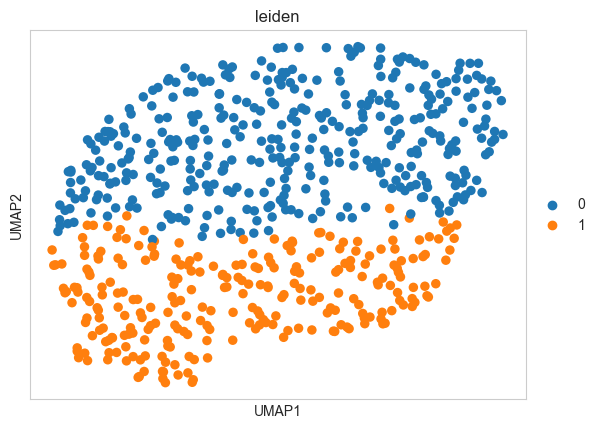

Resolution for two clusters: 0.18000000000000002


In [15]:
res2 = 0.01
twoclust = False

while twoclust is False:
    res2 += 0.01
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
sc.pl.umap(data_null_gen, color="leiden")
print(f"Resolution for two clusters: {res2}")

In [16]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

DEs_man = {}
pvals_man = {}
fdr = 0.1

for c in clusters_subset:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE, pval = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene.var[f"pval_cluster_{c}_man"] = pval["pval_data"]
    data_gene.var[f"q_cluster_{c}_man"] = pval["q"]
    data_gene.var[f"DE_cluster_{c}_man"] = (data_gene.var[f"q_cluster_{c}_man"] < fdr)
    
    DEs_man[c] = DE
    pvals_man[c] = pval
    print(f"Cluster {c} - DE genes: {len(DEs_man[c])}")

Cluster 0 - DE genes: 0
Cluster 3 - DE genes: 0


In [17]:
DEs_man_log = {}
pvals_man_log  = {}
fdr = 0.1

for c in clusters_subset:
    X_data_0 = data_gene.X[data_gene.obs["leiden_opt"] == c]
    X_data_1 = data_gene.X[data_gene.obs["leiden_opt"] != c]
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene.var.index)
    DE, pval = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene.var[f"pval_cluster_{c}_man"] = pval["pval_data"]
    data_gene.var[f"q_cluster_{c}_man"] = pval["q"]
    data_gene.var[f"DE_cluster_{c}_man"] = (data_gene.var[f"q_cluster_{c}_man"] < fdr)
    
    DEs_man_log [c] = DE
    pvals_man_log [c] = pval
    print(f"Cluster {c} - DE genes: {len(DEs_man_log [c])}")

Cluster 0 - DE genes: 4804
Cluster 3 - DE genes: 34


Empty DataFrame
Columns: [pval_data, pval_null, cs, q]
Index: []


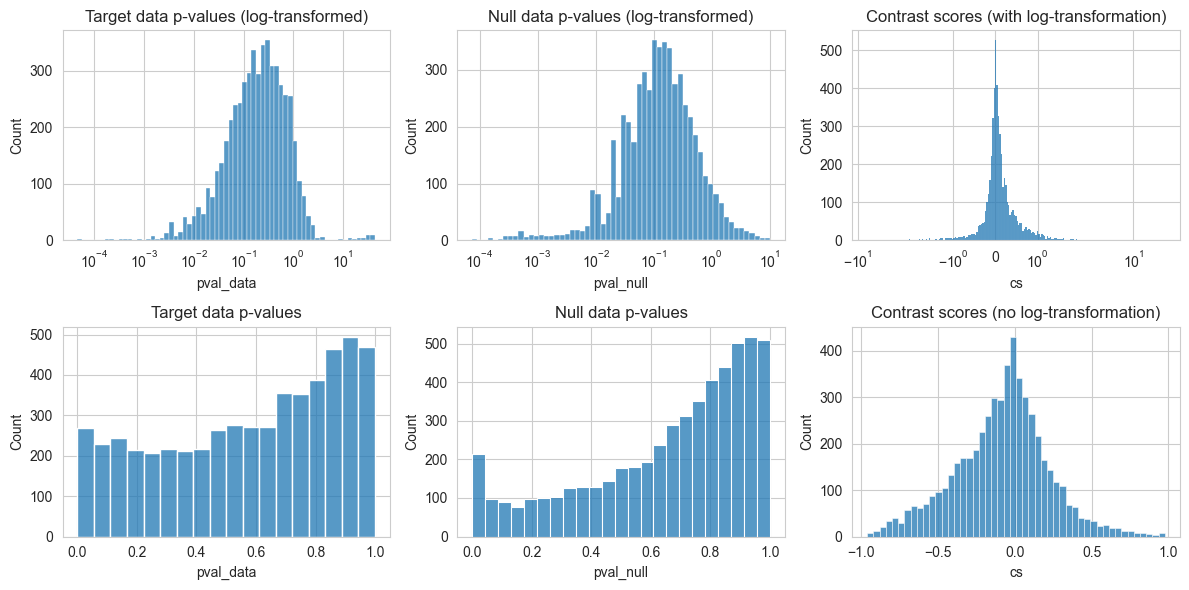

In [18]:
c = "3"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_man_log[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_man_log[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_man_log[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog")

sns.histplot(pvals_man[c], x="pval_data", ax=ax[1,0])
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_man[c], x="pval_null", ax=ax[1,1])
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_man[c], x="cs", ax=ax[1,2])
ax[1,2].set_title("Contrast scores (no log-transformation)")

print(DEs_man[c])


plt.tight_layout()
plt.show()